In [1]:
from google.colab import files
uploaded = files.upload()

Saving final_weekly_with_cta_rides_and_weather.csv to final_weekly_with_cta_rides_and_weather.csv


# **1. Data Preprocessing and EDA**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Load the data
data = pd.read_csv('data/final_weekly_with_cta_rides_and_weather.csv')

# Display basic information
print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nFirst few rows:")
print(data.head())

# Add a time index (since we don't have explicit dates)
# Assuming data is already sorted chronologically
data['time_index'] = range(len(data))
data.set_index('time_index', inplace=True)

# Summary statistics
print("\nSummary statistics:")
print(data.describe())

# Define our main variables of interest
divvy_var = 'Total Counts'  # Divvy bike counts
cta_var = 'total_rides'     # CTA rides
weather_vars = ['tavg', 'prcp', 'snow']  # Weather variables to use as exogenous

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

Data shape: (433, 18)
Columns: ['Total Counts', 'Casual User Count', 'Member User Count', 'Classic Bike Count', 'Electric Bike Count', 'bus', 'rail_boardings', 'total_rides', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']

First few rows:
   Total Counts  Casual User Count  Member User Count  Classic Bike Count  \
0         14961               4658              10302                   0   
1         88411              19247              69164                   0   
2         83531              18678              64849                   0   
3         82545              15590              66954                   0   
4         69579              12419              57159                   0   

   Electric Bike Count      bus  rail_boardings  total_rides   tavg   tmin  \
0                    0  5293780         4754018     10047798  16.76  13.97   
1                    0  5401326         5160414     10561740  17.73  13.26   
2                    0  5164349


Correlation matrix:
                Total Counts       bus  rail_boardings  total_rides      tavg  \
Total Counts        1.000000 -0.067879       -0.065546    -0.066907  0.880894   
bus                -0.067879  1.000000        0.982613     0.994908  0.029746   
rail_boardings     -0.065546  0.982613        1.000000     0.996322  0.049978   
total_rides        -0.066907  0.994908        0.996322     1.000000  0.040858   
tavg                0.880894  0.029746        0.049978     0.040858  1.000000   
prcp                0.034422  0.056509        0.069625     0.063875  0.185581   
snow               -0.282993 -0.128938       -0.105234    -0.116631 -0.370945   

                    prcp      snow  
Total Counts    0.034422 -0.282993  
bus             0.056509 -0.128938  
rail_boardings  0.069625 -0.105234  
total_rides     0.063875 -0.116631  
tavg            0.185581 -0.370945  
prcp            1.000000 -0.056412  
snow           -0.056412  1.000000  


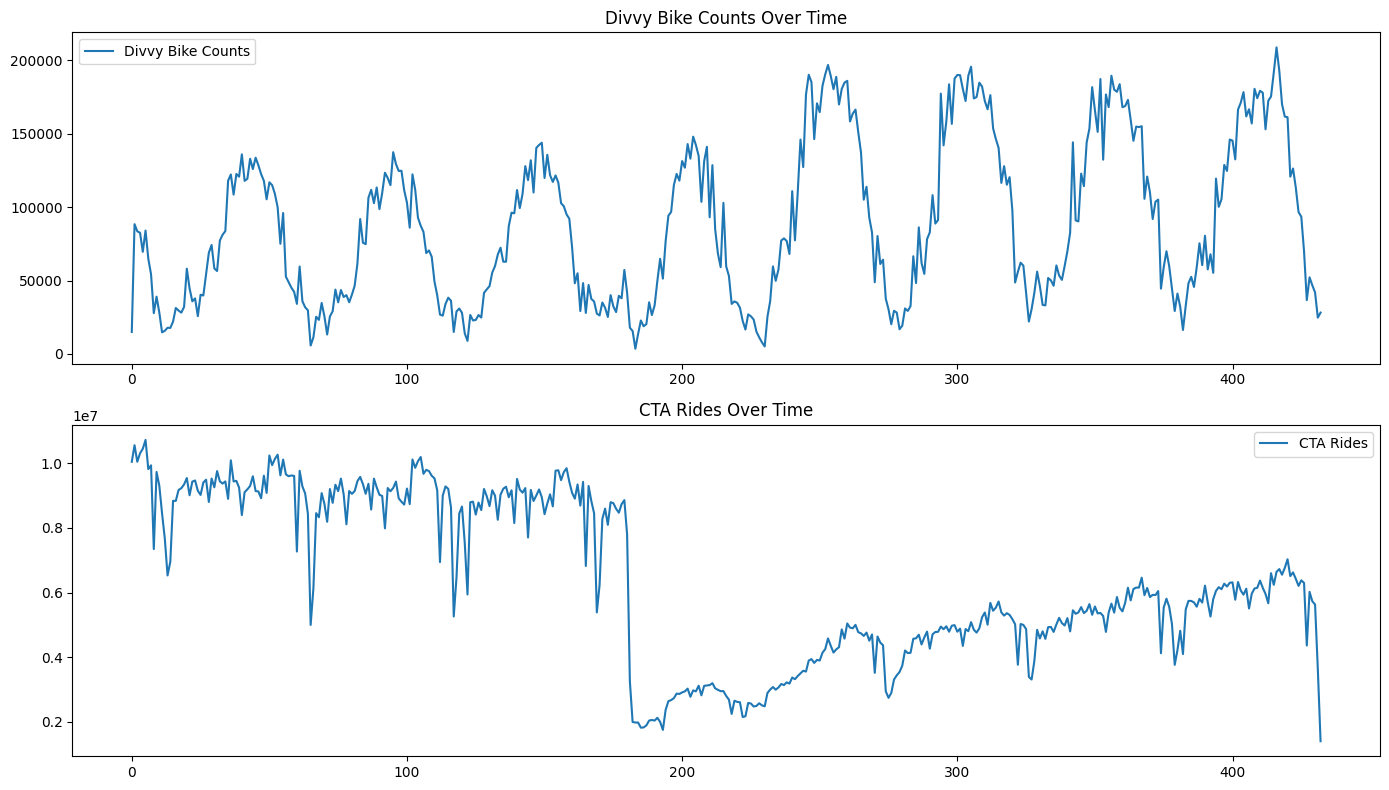

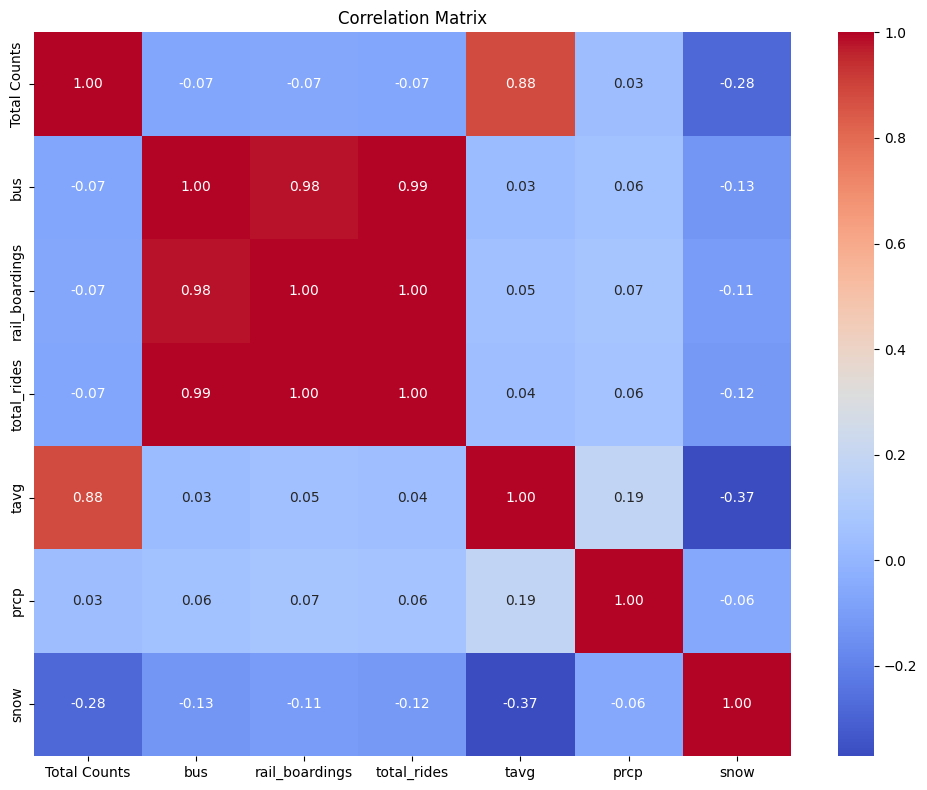

In [4]:
# Plot time series
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(data[divvy_var], label='Divvy Bike Counts')
plt.title('Divvy Bike Counts Over Time')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data[cta_var], label='CTA Rides')
plt.title('CTA Rides Over Time')
plt.legend()
plt.tight_layout()
plt.savefig('time_series_plot.png')

# Correlation analysis
corr_vars = [divvy_var, 'bus', 'rail_boardings', cta_var] + weather_vars
corr_matrix = data[corr_vars].corr()
print("\nCorrelation matrix:")
print(corr_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')

# **2. Stationarity Analysis**

In [13]:
# Check stationarity using Augmented Dickey-Fuller test
def test_stationarity(series, title):
    result = adfuller(series)
    print(f"\nADF Test for {title}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.4f}")

    # If p-value > 0.05, we cannot reject the null hypothesis,
    # which means the series is non-stationary
    if result[1] > 0.05:
        print(f"Series is non-stationary (p > 0.05)")
        return False
    else:
        print(f"Series is stationary (p <= 0.05)")
        return True

# Test stationarity for both series
divvy_stationary = test_stationarity(data[divvy_var], "Divvy Bike Counts")
cta_stationary = test_stationarity(data[cta_var], "CTA Rides")

# Difference CTA rides if non-stationary, but keep Divvy counts as is
if not cta_stationary:
    data['diff_cta'] = data[cta_var].diff().fillna(0)
    # Check stationarity of differenced CTA series
    diff_cta_stationary = test_stationarity(data['diff_cta'].iloc[1:], "Differenced CTA Rides")

# Keep original CTA values for back-transformation
original_cta = data[cta_var].copy()


ADF Test for Divvy Bike Counts
ADF Statistic: -7.7790
p-value: 0.0000
Critical Values:
	1%: -3.4460
	5%: -2.8684
	10%: -2.5704
Series is stationary (p <= 0.05)

ADF Test for CTA Rides
ADF Statistic: -1.4478
p-value: 0.5592
Critical Values:
	1%: -3.4460
	5%: -2.8684
	10%: -2.5704
Series is non-stationary (p > 0.05)

ADF Test for Differenced CTA Rides
ADF Statistic: -7.8480
p-value: 0.0000
Critical Values:
	1%: -3.4460
	5%: -2.8684
	10%: -2.5704
Series is stationary (p <= 0.05)


# **3. ACF and PACF Plots**

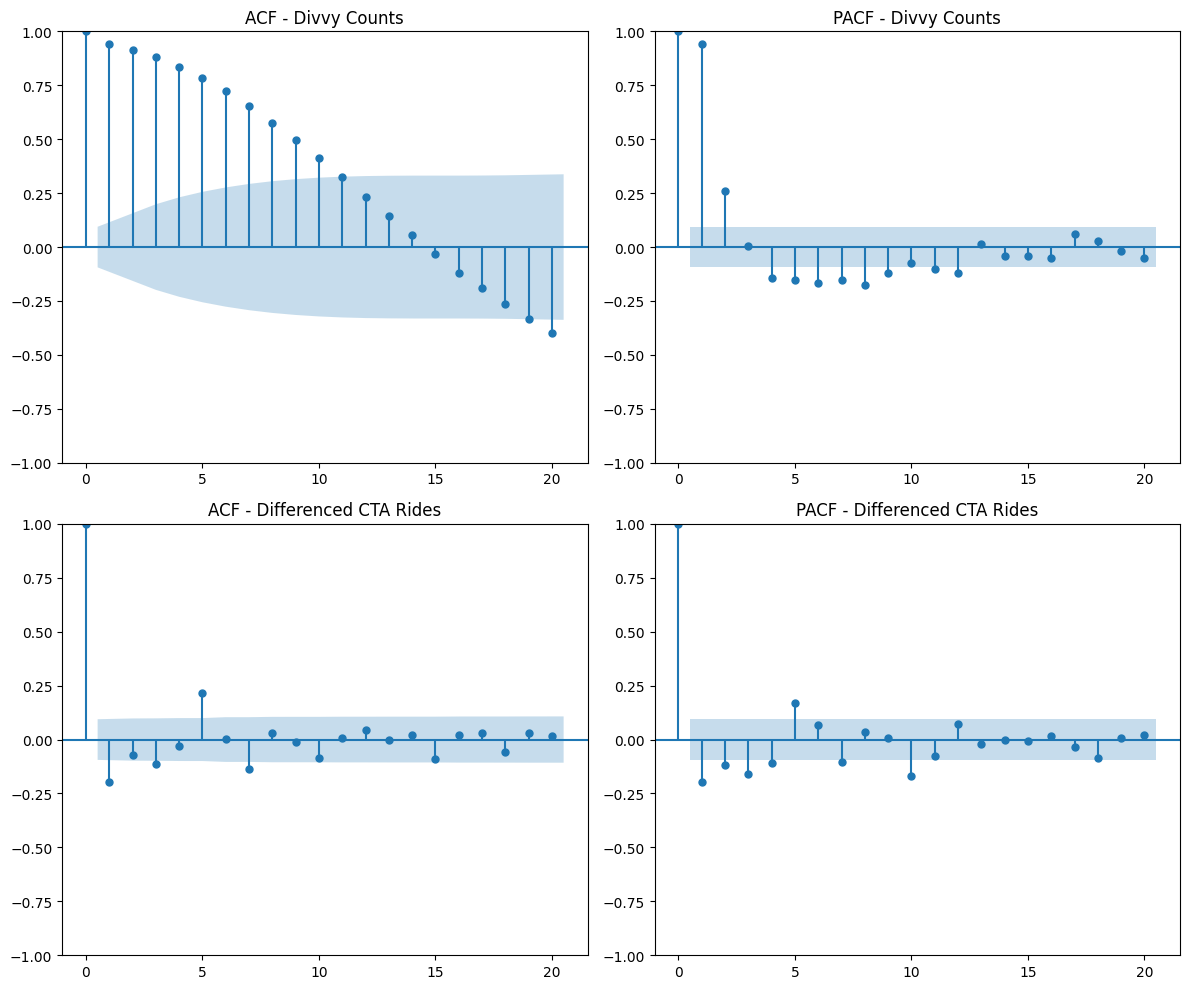

In [7]:
# Plot ACF and PACF of the original Divvy series and (potentially) differenced CTA series
plt.figure(figsize=(12, 10))

# Divvy ACF/PACF (original series since it's already stationary)
plt.subplot(2, 2, 1)
plot_acf(data[divvy_var], lags=20, ax=plt.gca(), title='ACF - Divvy Counts')

plt.subplot(2, 2, 2)
plot_pacf(data[divvy_var], lags=20, ax=plt.gca(), title='PACF - Divvy Counts')

# CTA ACF/PACF
# Use differenced CTA series
plt.subplot(2, 2, 3)
plot_acf(data['diff_cta'].iloc[1:], lags=20, ax=plt.gca(), title='ACF - Differenced CTA Rides')

plt.subplot(2, 2, 4)
plot_pacf(data['diff_cta'].iloc[1:], lags=20, ax=plt.gca(), title='PACF - Differenced CTA Rides')

plt.tight_layout()
plt.savefig('acf_pacf_plots.png')

**4. Granger Causality**

In [8]:
# Granger Causality Test to see if one series helps predict the other
# For CTA, use differenced series
cta_series = 'diff_cta'

# Null hypothesis: x does not Granger-cause y
print("\nGranger Causality Test (Divvy -> CTA):")
granger_data = pd.DataFrame({
    'cta': data[cta_series].iloc[1:] if not cta_stationary else data[cta_series],
    'divvy': data[divvy_var].iloc[1:] if not cta_stationary else data[divvy_var]
})
granger_cta = grangercausalitytests(granger_data[['cta', 'divvy']].dropna(), maxlag=4, verbose=False)
for lag, results in granger_cta.items():
    print(f"Lag {lag}: p-value = {results[0]['ssr_ftest'][1]:.4f}")

print("\nGranger Causality Test (CTA -> Divvy):")
granger_divvy = grangercausalitytests(granger_data[['divvy', 'cta']].dropna(), maxlag=4, verbose=False)
for lag, results in granger_divvy.items():
    print(f"Lag {lag}: p-value = {results[0]['ssr_ftest'][1]:.4f}")


Granger Causality Test (Divvy -> CTA):
Lag 1: p-value = 0.6204
Lag 2: p-value = 0.6758
Lag 3: p-value = 0.5672
Lag 4: p-value = 0.5215

Granger Causality Test (CTA -> Divvy):
Lag 1: p-value = 0.0144
Lag 2: p-value = 0.7742
Lag 3: p-value = 0.8889
Lag 4: p-value = 0.5198


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


# **5. VARMA Model**

In [9]:
# Standardize exogenous variables
scaler = StandardScaler()
exog_data = data[weather_vars].copy()
exog_scaled = pd.DataFrame(
    scaler.fit_transform(exog_data),
    columns=exog_data.columns,
    index=exog_data.index
)

# Create endogenous dataset: original Divvy + differenced CTA
endog = pd.DataFrame({
    'divvy': data[divvy_var].iloc[1:].values,
    'diff_cta': data['diff_cta'].iloc[1:].values
}, index=data.index[1:])

exog = exog_scaled.iloc[1:].copy()  # Match size of endog

# Train-test split (80% train, 20% test)
train_size = int(len(endog) * 0.8)
train_endog = endog.iloc[:train_size]
train_exog = exog.iloc[:train_size]
test_endog = endog.iloc[train_size:]
test_exog = exog.iloc[train_size:]

In [10]:
# Based on ACF/PACF and Granger causality results:
# Divvy shows AR(1) pattern
# Differenced CTA is close to white noise
# CTA Granger-causes Divvy at lag 1
# VARMA(1,1) is appropriate

# Fit VARMA model
print("Fitting VARMA(1,1) model...")
model = VARMAX(train_endog, exog=train_exog, order=(1, 1))
model_fit = model.fit(disp=False)
print(model_fit.summary())

# Diagnostics
print("\nModel AIC:", model_fit.aic)
print("Model BIC:", model_fit.bic)

Fitting VARMA(1,1) model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                             Statespace Model Results                            
Dep. Variable:     ['divvy', 'diff_cta']   No. Observations:                  345
Model:                       VARMAX(1,1)   Log Likelihood               -8915.919
                             + intercept   AIC                          17869.838
Date:                   Sat, 08 Mar 2025   BIC                          17942.865
Time:                           18:38:25   HQIC                         17898.921
Sample:                                0                                         
                                   - 345                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             0.30, 1.28   Jarque-Bera (JB):      145.99, 1395.98
Prob(Q):                        0.58, 0.26   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.48, 0.23   Skew:                      0.74, -1.63
Prob(H) (t

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
# Extract and interpret model coefficients
coefficients = model_fit.params
print("\nModel Coefficients:")
print(coefficients)

# Focus on the coefficient that shows CTA's influence on Divvy
# This should be the coefficient for L1.diff_cta in the divvy equation
divvy_equation_coeffs = coefficients[coefficients.index.str.endswith('.divvy')]
print("\nCoefficients for Divvy equation:")
print(divvy_equation_coeffs)

# Check if the coefficient for L1.diff_cta -> divvy is significant
# This corresponds to the Granger causality finding
print("\nEffect of lagged CTA changes on Divvy:")
print(coefficients.filter(like='L1.diff_cta', axis=0).filter(like='.divvy', axis=0))


Model Coefficients:
intercept.divvy             14592.441851
intercept.diff_cta           4013.119130
L1.divvy.divvy                  0.828495
L1.diff_cta.divvy              -0.006660
L1.divvy.diff_cta              -0.364531
L1.diff_cta.diff_cta            0.169818
L1.e(divvy).divvy              -0.162611
L1.e(diff_cta).divvy            0.005662
L1.e(divvy).diff_cta            2.072853
L1.e(diff_cta).diff_cta        -0.479853
beta.tavg.divvy              8065.585011
beta.prcp.divvy             -1190.497704
beta.snow.divvy               377.615764
beta.tavg.diff_cta          71555.743613
beta.prcp.diff_cta         -56569.072462
beta.snow.diff_cta         -13619.110365
sqrt.var.divvy              13179.774921
sqrt.cov.divvy.diff_cta    148672.305111
sqrt.var.diff_cta          724837.073235
dtype: float64

Coefficients for Divvy equation:
intercept.divvy         14592.441851
L1.divvy.divvy              0.828495
L1.diff_cta.divvy          -0.006660
L1.e(divvy).divvy          -0.162611
L1.

# **6. Forecasting and Error Metrics**

In [14]:
# Generate forecasts
forecast_steps = len(test_endog)
forecast = model_fit.forecast(steps=forecast_steps, exog=test_exog)

# Back-transform CTA forecasts to original scale
last_train_cta = original_cta.iloc[train_size - 1]
backtransformed_cta = [last_train_cta]

for i in range(len(forecast)):
    next_cta = backtransformed_cta[-1] + forecast.iloc[i, 1]
    backtransformed_cta.append(next_cta)

backtransformed_cta = backtransformed_cta[1:]  # Remove starting value

# Create forecast DataFrame in original scale
forecast_original = pd.DataFrame({
    'divvy': forecast.iloc[:, 0].values,
    'cta': backtransformed_cta
}, index=forecast.index)

# Create actual values DataFrame in original scale
actual_original = pd.DataFrame({
    'divvy': test_endog.iloc[:, 0].values,
    'cta': original_cta.iloc[train_size:train_size+forecast_steps].values
}, index=test_endog.index)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q

In [15]:
# Calculate error metrics in original scale
mse = {
    'divvy': mean_squared_error(actual_original['divvy'], forecast_original['divvy']),
    'cta': mean_squared_error(actual_original['cta'], forecast_original['cta'])
}
mae = {
    'divvy': mean_absolute_error(actual_original['divvy'], forecast_original['divvy']),
    'cta': mean_absolute_error(actual_original['cta'], forecast_original['cta'])
}

# Calculate percentage errors for better interpretation
mape = {
    'divvy': np.mean(np.abs((actual_original['divvy'] - forecast_original['divvy']) / actual_original['divvy'])) * 100,
    'cta': np.mean(np.abs((actual_original['cta'] - forecast_original['cta']) / actual_original['cta'])) * 100
}

print("\nForecast Evaluation (in original scale):")
print(f"Divvy MSE: {mse['divvy']:.2f}")
print(f"Divvy MAE: {mae['divvy']:.2f}")
print(f"Divvy MAPE: {mape['divvy']:.2f}%")
print(f"\nCTA MSE: {mse['cta']:.2f}")
print(f"CTA MAE: {mae['cta']:.2f}")
print(f"CTA MAPE: {mape['cta']:.2f}%")


Forecast Evaluation (in original scale):
Divvy MSE: 1274412750.76
Divvy MAE: 30411.64
Divvy MAPE: 27.97%

CTA MSE: 1677466945646.36
CTA MAE: 1049174.59
CTA MAPE: 17.91%


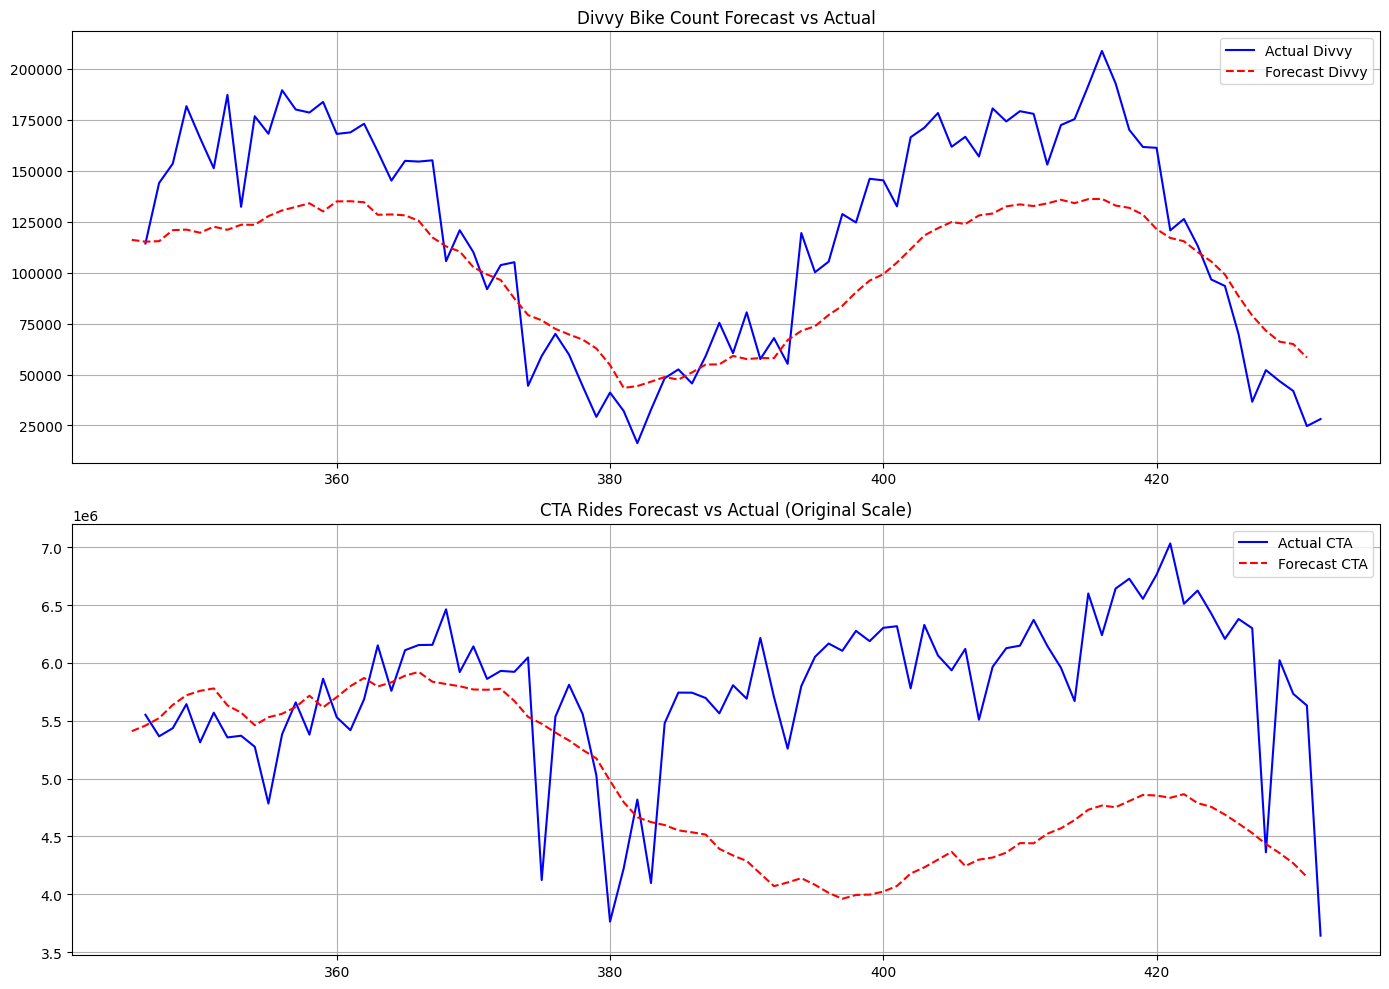

In [16]:
# Plot forecasts vs actual
plt.figure(figsize=(14, 10))

# Divvy forecasts
plt.subplot(2, 1, 1)
plt.plot(actual_original.index, actual_original['divvy'], 'b-', label='Actual Divvy')
plt.plot(forecast_original.index, forecast_original['divvy'], 'r--', label='Forecast Divvy')
plt.title('Divvy Bike Count Forecast vs Actual')
plt.legend()
plt.grid(True)

# CTA forecasts
plt.subplot(2, 1, 2)
plt.plot(actual_original.index, actual_original['cta'], 'b-', label='Actual CTA')
plt.plot(forecast_original.index, forecast_original['cta'], 'r--', label='Forecast CTA')
plt.title('CTA Rides Forecast vs Actual (Original Scale)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('forecast_comparison.png')

# **7. Weather Effects**


All model coefficients:
intercept.divvy             14592.441851
intercept.diff_cta           4013.119130
L1.divvy.divvy                  0.828495
L1.diff_cta.divvy              -0.006660
L1.divvy.diff_cta              -0.364531
L1.diff_cta.diff_cta            0.169818
L1.e(divvy).divvy              -0.162611
L1.e(diff_cta).divvy            0.005662
L1.e(divvy).diff_cta            2.072853
L1.e(diff_cta).diff_cta        -0.479853
beta.tavg.divvy              8065.585011
beta.prcp.divvy             -1190.497704
beta.snow.divvy               377.615764
beta.tavg.diff_cta          71555.743613
beta.prcp.diff_cta         -56569.072462
beta.snow.diff_cta         -13619.110365
sqrt.var.divvy              13179.774921
sqrt.cov.divvy.diff_cta    148672.305111
sqrt.var.diff_cta          724837.073235
dtype: float64

Weather Effects:
            Divvy           CTA
tavg  8065.585011  71555.743613
prcp -1190.497704 -56569.072462
snow   377.615764 -13619.110365


<Figure size 1000x600 with 0 Axes>

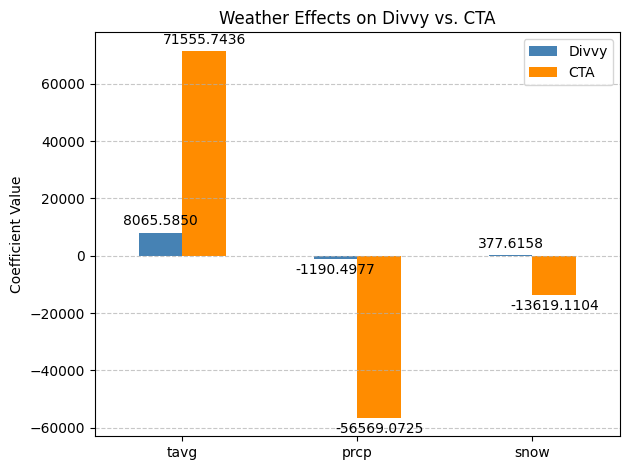

In [19]:
# Fix for the Weather Effects Analysis
print("\nAll model coefficients:")
print(model_fit.params)  # First print all coefficients to see their actual names

# Correctly extract the weather coefficients from the model
exog_names = ['tavg', 'prcp', 'snow']
weather_coeffs = pd.DataFrame(index=exog_names)

# Loop through the coefficient names to find the weather variables
for param_name in model_fit.params.index:
    for weather_var in exog_names:
        if weather_var in param_name:
            # Determine which equation this coefficient belongs to
            if '.divvy' in param_name:
                weather_coeffs.loc[weather_var, 'Divvy'] = model_fit.params[param_name]
            elif '.diff_cta' in param_name:
                weather_coeffs.loc[weather_var, 'CTA'] = model_fit.params[param_name]

# Fill NaN values with zeros
weather_coeffs = weather_coeffs.fillna(0)

print("\nWeather Effects:")
print(weather_coeffs)

# Visualize weather effects
plt.figure(figsize=(10, 6))
ax = weather_coeffs.plot(kind='bar', color=['steelblue', 'darkorange'])
plt.title('Weather Effects on Divvy vs. CTA')
plt.ylabel('Coefficient Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)  # Keep x labels horizontal

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.savefig('weather_effects.png')

The VARMA model for Divvy and CTA data offers several advantages: it successfully incorporates weather effects, with temperature showing strong positive impacts on both transportation modes (significant at p<0.001). It appropriately handles the differing stationarity properties of each series; and delivers reasonable forecasting accuracy for CTA rides (17.91% MAPE). However, the model has notable limitations: despite Granger causality tests suggesting CTA influences Divvy, this relationship appears weak in the model coefficients (-0.00666, p=0.156); forecasts consistently underpredict peaks in Divvy usage (27.97% MAPE); and the model struggles with extreme fluctuations, particularly for CTA rides. Additionally, the covariance matrix warnings suggest potential numerical instability. While effective for quantifying weather impacts, the model is less successful at capturing the dynamic relationship between the two transportation systems, indicating that simpler, separate models might perform better than this unified approach.